In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from functools import  total_ordering

def get_values(data):
    result = []
    for x in data:
        result.append(x.value)
    return result

def get_deltas(data):
    result = []
    for x in data:
        result.append(x.delta)
    return result

def kovar(x_data, y_data):
    x = np.array(x_data)
    y = np.array(y_data)
    return (x*y).mean() - x.mean() * y.mean()

def mnk_non_zero(x_data, y_data):
    x =  np.array(x_data)
    y = np.array(y_data)
    k = kovar(x, y) / kovar (x, x)
    b = y.mean()-k*x.mean()

    sigma_k = ((kovar(y, y)/kovar(x,x) - k**2) / (len(x)-2) )**0.5
    sigma_b = sigma_k * (x**2).mean()**0.5
    return (DData(k, sigma_k)), (DData(b, sigma_b))

def linearcalc(x, y, xmin = 0, xmax = 0):
    plt.grid(True)
    plt.plot(x, y, "o")
    k, b = mnk_non_zero(x, y)
    xl = np.array([min(x.min(), xmin), max(xmax, x.max())])
    plt.plot(xl, xl*k.value + b.value)
    print("k, b =", k, b)
    return k, b

class SerDData():
    """Запихиваешь сюда свою дату похожу на пандасовсвую серию и вызываешь ее параметры"""
    def __init__(self, data):
        try:
            self.data = pd.Series(data)
            self.data = self.data.dropna()
            self.data = self.data.apply(SerDData.ConvertIfNotDData)
        except:
            raise Exception(f"Нифига не получилось. data = {data}")
        
    def ConvertIfNotDData(x):
        if(type(x) != DData):
            return DData(x)
    @property
    def sigmaRaspr(self):    
        mean = self.meanValue
        return (self.data.map(lambda x: (x.value - mean)**2).sum()/len(self.data))**0.5

    @property
    def meanValue(self):    
        return self.meanStupid.value

    @property
    def sigmaSluch(self):
        n = len(self.data)
        return(self.sigmaRaspr / (n*(n-1))**0.5)
    
    @property
    def sigmaPrib(self):
        return self.meanStupid.delta
    
    @property
    def meanStupid(self):
        result = self.data.sum()/len(self.data)
        result.delta *= (len(self.data))**0.5
        return(result)

    @property
    def mean(self):
        mean = self.meanStupid
        mean.delta = (mean.delta**2 + self.sigmaSluch**2)**0.5
        return mean

    @property
    def sigma(self):
        return self.mean.delta
    
@total_ordering
class DData():
    def __init__(self, value = 0, delta = 0, epsilon = 0, E = 0):
        self.__value = 0
        self.__delta = 0
        self.__E = E
        self.value = value
        assert (delta == 0 or epsilon == 0), "При задании можно указать только один тип погрешности"
        
        if(delta!=0):
            self.delta = delta
        elif(epsilon!=0):
            self.epsilon = epsilon
    
    @property
    def E(self):
        return self.__E
    
    @E.setter
    def E(self, value):
        self.value *= 10**(self.E-value)
        self.delta *= 10**(self.E-value)
        self.__E = value

    @property
    def value(self):
        return self.__value

    @value.setter
    def value(self, value):
        if(isinstance(value, DData)):
            self.__value = value.value
            self.__delta = value.delta
            self.__E = value.E
        elif(isinstance(value, (int, float))):
            self.__value = value 
        else:
            assert False, "Значение должно быть числом"

    @property
    def epsilon(self):
        if(self.value == 0):
            return 0
        return self.delta/self.value
    @epsilon.setter
    def epsilon(self, epsilon):
        self.delta = abs(self.value*epsilon)

    @property
    def delta(self):
        return self.__delta
    @delta.setter
    def delta(self, delta):
        self.__delta = delta

    def __str__(self):
        #return(f"{self.__value} \\pm {self.__delta}")
        return self.LaTeX()
    def to_str(self, LaTeX = False, E = False):
        try:
            if(self.delta != 0):
                znak = -int((np.log10(self.delta))//1)+1
            else:
                znak = 1
        except:
            warnings.warn(f"попытка вывести какую-то хрень. value = {self.value}, delta = {self.delta}")
            return "NaN"
        try:
            form = f".{znak}f"
            value_str = round(self.value, znak)

            delta_str = round(self.delta, znak)

            value_str = format(value_str, form)
            delta_str = format(delta_str, form)

            if LaTeX:
                return f"${value_str} \pm {delta_str}$"
            elif not E or self.E == 0:

                return (f"{value_str} \pm {delta_str}")
            else:
                return (f"{value_str} \pm {delta_str} \cdot 10^{E}")
        except:
            warnings.warn("Что-то сломалось при отображении ")
            return f"${round(self.value, znak)} \pm {round(self.delta, znak)}$"
    def __neg__(self):
        return DData(-self.value, self.delta, E = self.E)

    def __add__(self, other):
        other = DData(other)
        if(self.E == other.E):
            return(DData(self.value + other.value, (self.delta**2 + other.delta**2)**0.5, E = self.E))
        else:
            newE = min(self.E, other.E)
            other.E = newE
            newSelf = DData(self)
            newSelf.E = newE
            return(newSelf+other)
        
    
    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return -(self - other)
    
    def __mul__(self, other):
        other = DData(other)
        return DData(self.value * other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E + other.E)
        
    def __rmul__(self, other):
        return self*other
        
    def __truediv__(self, other):
        if(isinstance(other, (int, float, DData))):
            other = DData(other)
            return DData(self.value / other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E - other.E)
        elif (isinstance(other, pd.Series)):
            return 1/other * self
        else:
            assert False, f"А фиг тебе, я не умею делить на {other} типа {type(other)}"
        
    def __rtruediv__(self, other):
        return (DData(1)/self) * other
    
    def __pow__(self, other):
        if(isinstance(other, (int, float))):
            return DData(self.value**other, epsilon=other*self.epsilon, E = self.E * other)
        else:
            assert False, "Пока можно возводить только в степень точного числа"
    
    def __eq__(self, other):
        return (self.value == other.value) and (self.delta == other.delta)

    def __lt__(self, other):
        return (self.value < other.value)

    def LaTeX(self):
        return self.to_str(True)
    
    def changeE(self, E):
        try:
            self.E = E
            return True
        except:
            return False

    @staticmethod
    def tryConvert(x, delta = 0, epsilon = 0, E = 0):
        try:
            if(pd.isna(x)):
                return x
            return DData(float(x), delta = delta, epsilon = epsilon, E = E)
        except:
            return x
    def changeEInSerias(series : pd.Series, E):
        series.dropna().apply(lambda x: x.changeE(E))



In [185]:
v0 = DData(252,1)
p = pd.Series([10**5, 2.70*10**4, 2.25*10**4, 1.64*10**4, 1.37*10**4])
p = p.apply(lambda x: DData(x, epsilon=0.01))
v = v0*10**5/p
v

0    $252.0 \pm 2.7$
1       $933 \pm 10$
2      $1120 \pm 12$
3      $1537 \pm 17$
4      $1839 \pm 20$
dtype: object

In [186]:
data = pd.read_csv("data_pars.csv", sep=";")

In [187]:
def T_srez(a, b, ObjectName, srezData = data):
    srezan = srezData[srezData["Sec"]<=b][srezData["Sec"]>=a][srezData["Object Name"] == ObjectName]

    return srezan[srezan["Value"] < 1000000]

In [188]:
p = []
p.append(100000)
p.append(SerDData(T_srez(2850, 2920, "TIC Gauge 1")["Value"]).mean)
p.append(SerDData(T_srez(2941, 2961, "TIC Gauge 1")["Value"]).mean)
p.append(SerDData(T_srez(2970, 3027, "TIC Gauge 1")["Value"]).mean)
p.append(SerDData(T_srez(3055, 3083, "TIC Gauge 1")["Value"]).mean)

p = pd.Series(p)
v0 = DData(252, 1)
p0 = 100000
v = v0*p0/p
v1 = pd.Series([v[0], v[1]-v[0], v[2]-v[1], v[3] - v[2], v[4] - v[3]])

v_frame = pd.DataFrame()
v_frame["P, Па"] = p
v_frame["V общий, мл"] = v
v_frame["V добавленный, мл"] = v1
v_frame["Название добавленной части"] = pd.Series(["Сильфон", "Камера", "Форвакуумная магистраль", "ТМН", "Масленная ловушка и форвакуумный насос"])
v_kamera = v_frame["V добавленный, мл"][1]/10**6
v_frame

C:\Users\redbr\AppData\Local\Temp\ipykernel_20744\3207634229.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  srezan = srezData[srezData["Sec"]<=b][srezData["Sec"]>=a][srezData["Object Name"] == ObjectName]
C:\Users\redbr\AppData\Local\Temp\ipykernel_20744\3207634229.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  srezan = srezData[srezData["Sec"]<=b][srezData["Sec"]>=a][srezData["Object Name"] == ObjectName]
C:\Users\redbr\AppData\Local\Temp\ipykernel_20744\3207634229.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  srezan = srezData[srezData["Sec"]<=b][srezData["Sec"]>=a][srezData["Object Name"] == ObjectName]
C:\Users\redbr\AppData\Local\Temp\ipykernel_20744\3207634229.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  srezan = srezData[srezData["Sec"]<=b][srezData["Sec"]>=a][srezData["Object Name"] == ObjectName]
C:\Users\redbr\AppData\Local\Tem

,"P, Па","V общий, мл","V добавленный, мл",Название добавленной части
0,100000,$252.0 \pm 1.0$,$252.0 \pm 1.0$,Сильфон
1,$27318 \pm 11$,$922.5 \pm 3.7$,$670.5 \pm 3.8$,Камера
2,$22619.5 \pm 5.2$,$1114.1 \pm 4.4$,$191.6 \pm 5.8$,Форвакуумная магистраль
3,$16465.1 \pm 1.8$,$1530.5 \pm 6.1$,$416.4 \pm 7.5$,ТМН
4,$13536.7 \pm 2.4$,$1861.6 \pm 7.4$,$331.1 \pm 9.6$,Масленная ловушка и форвакуумный насос


In [189]:
v_frame.to_clipboard()

In [190]:
for_vac = T_srez(80, 100, "TIC Gauge 1")


C:\Users\redbr\AppData\Local\Temp\ipykernel_20744\3207634229.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  srezan = srezData[srezData["Sec"]<=b][srezData["Sec"]>=a][srezData["Object Name"] == ObjectName]
C:\Users\redbr\AppData\Local\Temp\ipykernel_20744\3207634229.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  srezan = srezData[srezData["Sec"]<=b][srezData["Sec"]>=a][srezData["Object Name"] == ObjectName]


k, b = $-0.340 \pm 0.013$ $38.5 \pm 1.2$


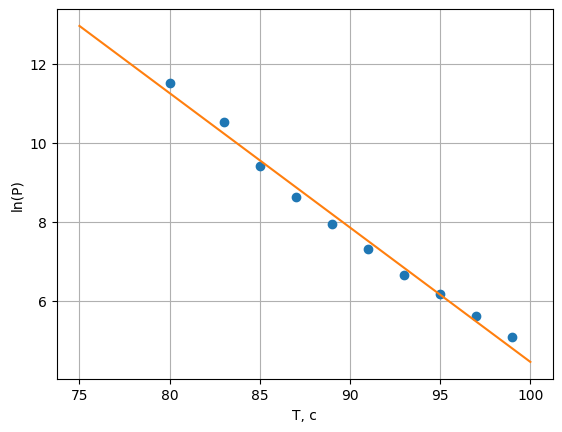

In [191]:
plt.xlabel("T, с")
plt.ylabel("ln(P)")
k_for, _ = linearcalc(for_vac["Sec"], np.log(for_vac["Value"]), 75, 100)
plt.savefig("for_log", dpi = 300)


In [199]:
Tao = 1/k_for
print(Tao, v_kamera, "\n", -3600*k_for*v_kamera)

$-2.94 \pm 0.11$ $0.0006705 \pm 0.0000038$ 
 $0.821 \pm 0.032$


C:\Users\redbr\AppData\Local\Temp\ipykernel_20744\3207634229.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  srezan = srezData[srezData["Sec"]<=b][srezData["Sec"]>=a][srezData["Object Name"] == ObjectName]
C:\Users\redbr\AppData\Local\Temp\ipykernel_20744\3207634229.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  srezan = srezData[srezData["Sec"]<=b][srezData["Sec"]>=a][srezData["Object Name"] == ObjectName]
C:\Users\redbr\AppData\Local\Temp\ipykernel_20744\3207634229.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  srezan = srezData[srezData["Sec"]<=b][srezData["Sec"]>=a][srezData["Object Name"] == ObjectName]
C:\Users\redbr\AppData\Local\Temp\ipykernel_20744\3207634229.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  srezan = srezData[srezData["Sec"]<=b][srezData["Sec"]>=a][srezData["Object Name"] == ObjectName]
C:\Users\redbr\AppData\Local\Tem

k, b = $-0.139 \pm 0.011$ $745 \pm 61$
k, b = $-0.002 \pm 0.027$ $0.0 \pm 140.0$
$-7.18 \pm 0.59$ $-600.0 \pm 9900.0$
$-0.0000934 \pm 0.0000077$ $-0.000001 \pm 0.000018$


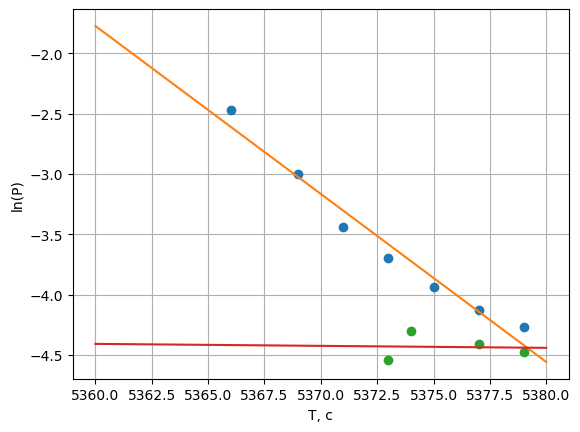

In [216]:
a = 5360
b = 5380
turbo_mol_2 = T_srez(a, b, "TIC Gauge 2")
turbo_mol_3 = T_srez(a, b, "TIC Gauge 3")
turbo_mol_3 = turbo_mol_3[turbo_mol_3["Value"] < 10000]

plt.xlabel("T, с")
plt.ylabel("ln(P)")
k1, _ = linearcalc(turbo_mol_2["Sec"],  np.log(turbo_mol_2["Value"]), a, b)
k2, _ = linearcalc(turbo_mol_3["Sec"], np.log(turbo_mol_3["Value"]), a, b)


print(1/k1, 1/k2)
print(v_kamera*k1, v_kamera*k2)

k, b = $-0.002184 \pm 0.000037$ $4.54 \pm 0.16$
k, b = $-0.003496 \pm 0.000037$ $10.16 \pm 0.16$
$-457.9 \pm 7.7$ $-286.0 \pm 3.0$
$-0.001464 \pm 0.000026$ $-0.002344 \pm 0.000028$


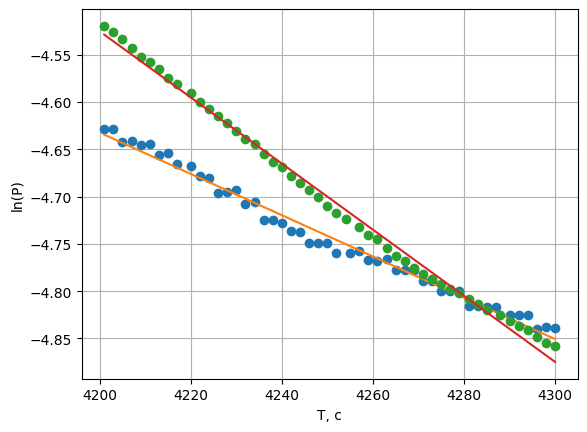

C:\Users\redbr\AppData\Local\Temp\ipykernel_20744\3207634229.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  srezan = srezData[srezData["Sec"]<=b][srezData["Sec"]>=a][srezData["Object Name"] == ObjectName]
C:\Users\redbr\AppData\Local\Temp\ipykernel_20744\3207634229.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  srezan = srezData[srezData["Sec"]<=b][srezData["Sec"]>=a][srezData["Object Name"] == ObjectName]
C:\Users\redbr\AppData\Local\Temp\ipykernel_20744\3207634229.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  srezan = srezData[srezData["Sec"]<=b][srezData["Sec"]>=a][srezData["Object Name"] == ObjectName]


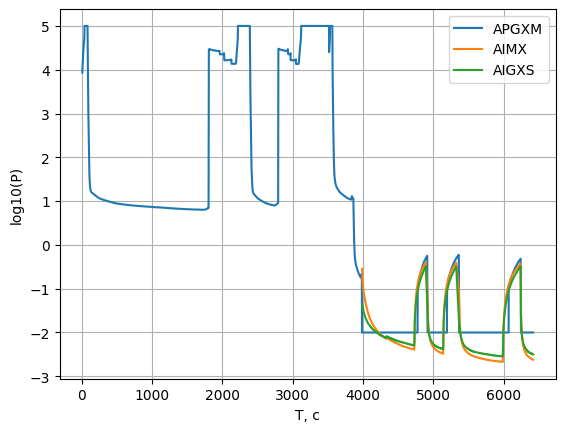

In [195]:
plt.xlabel("T, с")
plt.ylabel("log10(P)")
plt.grid(True)
a = 5
b = 6421
tg1 = T_srez(a, b, "TIC Gauge 1")
tg2 = T_srez(a, b, "TIC Gauge 2")
tg3 = T_srez(a, b, "TIC Gauge 3")
plt.plot(tg1["Sec"], np.log10(tg1["Value"]), label = "APGXM")
plt.plot(tg2["Sec"], np.log10(tg2["Value"]), label = "AIMX")
plt.plot(tg3["Sec"], np.log10(tg3["Value"]), label = "AIGXS")
plt.legend()
plt.savefig("all_time_1", dpi = 300)

C:\Users\redbr\AppData\Local\Temp\ipykernel_20744\3207634229.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  srezan = srezData[srezData["Sec"]<=b][srezData["Sec"]>=a][srezData["Object Name"] == ObjectName]
C:\Users\redbr\AppData\Local\Temp\ipykernel_20744\3207634229.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  srezan = srezData[srezData["Sec"]<=b][srezData["Sec"]>=a][srezData["Object Name"] == ObjectName]
C:\Users\redbr\AppData\Local\Temp\ipykernel_20744\3207634229.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  srezan = srezData[srezData["Sec"]<=b][srezData["Sec"]>=a][srezData["Object Name"] == ObjectName]


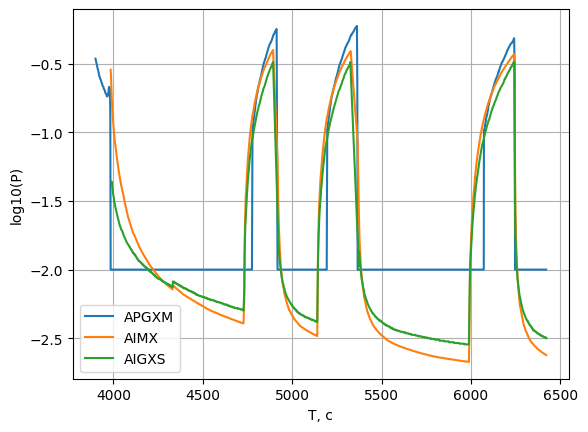

In [196]:
plt.xlabel("T, с")
plt.ylabel("log10(P)")
plt.grid(True)
a = 3900
b = 6421
tg1 = T_srez(a, b, "TIC Gauge 1")
tg2 = T_srez(a, b, "TIC Gauge 2")
tg3 = T_srez(a, b, "TIC Gauge 3")
plt.plot(tg1["Sec"], np.log10(tg1["Value"]), label = "APGXM")
plt.plot(tg2["Sec"], np.log10(tg2["Value"]), label = "AIMX")
plt.plot(tg3["Sec"], np.log10(tg3["Value"]), label = "AIGXS")
plt.legend()
plt.savefig("all_time_2", dpi = 300)